# 01 - Notebook settings
Makes it easier to call tailor made modules, classes, and functions from other directory structures 

In [1]:
import sys
import os

# Get the directory where your notebook is running (which is /app/notebooks)
notebook_dir = os.path.dirname(os.path.abspath(''))

# Add the parent directory (/app) to the Python path
# This allows imports like 'from etl_development.my_etl_module import ...'
if '/app' not in sys.path:
    sys.path.insert(0, '/app') # Add /app to the beginning of the path for highest priority

print(f"Current Python Path: {sys.path}")

Current Python Path: ['/app', '/usr/local/lib/python39.zip', '/usr/local/lib/python3.9', '/usr/local/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/site-packages']


# 02 - Paths, packages/libraries

In [2]:
import json
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, TimestampType, DoubleType, IntegerType, TimestampType
from pyspark.sql.functions import col, from_unixtime, round as spark_round, col, to_date, when, regexp_replace, year, quarter, concat, lit, when, month, ceil, date_format, countDistinct
import shutil # Integration with version control platforms (github, gitlab, etc.)
import datetime

# Pathways to (1) data, 
# (2) output data quality/profiling used to examine and determine transformation requirements, 
# (3) star schema output (warehouse)
fpath_tenancy_data = '../src_data/sample.json'
fpath_etl_code = '../app/etl_development/'
fpath_data_quality_profile = '/app/data_quality_profiles/'
fpath_data_star_schema = '../data_star_schema_prep/ais_data_by_hr'

# 03 - ETL 
- Due to the original file size, as well as determined nested data structures, this section of the code uses a tailor made ETL class (which is configured to limit records/memory and exists in the etl_development directory)
- The resulting dataframe is then partitioned (by hierarchy using year, month, day, and hour) then saved (within the data star schema prep directory)

In [ ]:
from etl_development.etl import etlprocess
from etl_development.partitiondata import savedata

# Initialize 
processor = etlprocess(
    app_name="MyJupyterNotebookApp",
    spark_config={
        "spark.driver.memory": "8g", # Example: more driver memory
        "spark.driver.maxResultSize": "4g",
        "spark.sql.adaptive.enabled": "true"}
)

# This ETL's the source data, resulting in a transformed dataframe (df)
df = processor.process_file(fpath_tenancy_data, max_memory_mb=2048)

if df:
    print("\nDataFrame returned to Jupyter Notebook:")
    df.printSchema()
    df.show(5, truncate=False)
    
    df.cache() # Cache the DataFrame if you plan to reuse it in the notebook
    print(f"\nDataFrame cached with {df.count():,} total records")

    # --- Step 3: Jupyter Notebook initializes and calls ParquetSaver ---
    print("\n--- Step 3: Saving DataFrame to partitioned Parquet ---")
    save_data = savedata()
    save_data.save_partitioned_dataframe(df, fpath_data_star_schema)
else:
    print("No DataFrame was processed by JSONDataProcessor.")

# --- Step 4: Stop the SparkSession when all operations are complete ---
print("\n--- Step 4: Stopping Spark Session ---")

processor.spark.stop()
print("Spark Session stopped.")

# 04 - Reload Data

In [4]:
# 03 ETL'd the data, this reloads the data 
spark = SparkSession.builder \
    .appName("ReadPartitionedData") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Read all partitioned data
df_all = spark.read.parquet(fpath_data_star_schema)

print(f"Successfully loaded {df_all.count():,} records")
print("\nSchema:")
df_all.printSchema()

print("\nSample data:")
df_all.show(10, truncate=False)

Successfully loaded 8,955,836 records

Schema:
root
 |-- DateTime: timestamp (nullable = true)
 |-- UTCTimeStamp: integer (nullable = true)
 |-- Message_MessageID: integer (nullable = true)
 |-- Message_UserID: integer (nullable = true)
 |-- Message_Latitude: double (nullable = true)
 |-- Message_Longitude: double (nullable = true)
 |-- Message_SOG: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)


Sample data:


+-------------------+------------+-----------------+--------------+----------------+-----------------+-----------+----+-----+---+----+
|DateTime           |UTCTimeStamp|Message_MessageID|Message_UserID|Message_Latitude|Message_Longitude|Message_SOG|year|month|day|hour|
+-------------------+------------+-----------------+--------------+----------------+-----------------+-----------+----+-----+---+----+
|2020-05-05 19:00:00|1588705200  |18               |412320027     |-23.871741      |177.669108       |NULL       |2020|5    |5  |19  |
|2020-05-05 19:00:00|1588705200  |18               |416003472     |-4.214785       |163.920411       |NULL       |2020|5    |5  |19  |
|2020-05-05 19:00:00|1588705200  |18               |503065470     |-27.634673      |153.375383       |NULL       |2020|5    |5  |19  |
|2020-05-05 19:00:00|1588705200  |18               |503079680     |-30.303296      |153.14384        |NULL       |2020|5    |5  |19  |
|2020-05-05 19:00:00|1588705200  |18               |525

# 05 - Basic Counts - Records in general
- Removed fields of little use (i.e. SOGs had no values - all null).
- Retained DateTime, Hour, Longitude, Latitude, UserID, and MessageID fields.
- Inspection of the number of records (in both the table and line chart) indicates majority of AIS records tended to occur between 5am-10am and 5pm-10pm

A majority of messaging records occur between 5am-10am and 5pm-8pm. 
During the above periods, the number of vessels appear indifferent ...
- from midnight through to 11am (with vessel counts oscillating around 9.6K vessels per hr 
	- Between 5-8am, messaging per vessel rises to around 40 messages per vessel). 


--- Aggregated Data Table ---


,hour,Records_per_hr,Vessels,AverageMessagesPerVesselPerHour
0,0,344409,9588,35.920000
1,1,387666,9689,40.010000
2,2,382022,9519,40.130000
3,3,344815,9582,35.990000
4,4,379317,9467,40.070000
5,5,430551,9712,44.330000
6,6,363306,9422,38.560000
7,7,422981,9434,44.840000
8,8,396270,9467,41.860000
9,9,374627,9610,38.980000


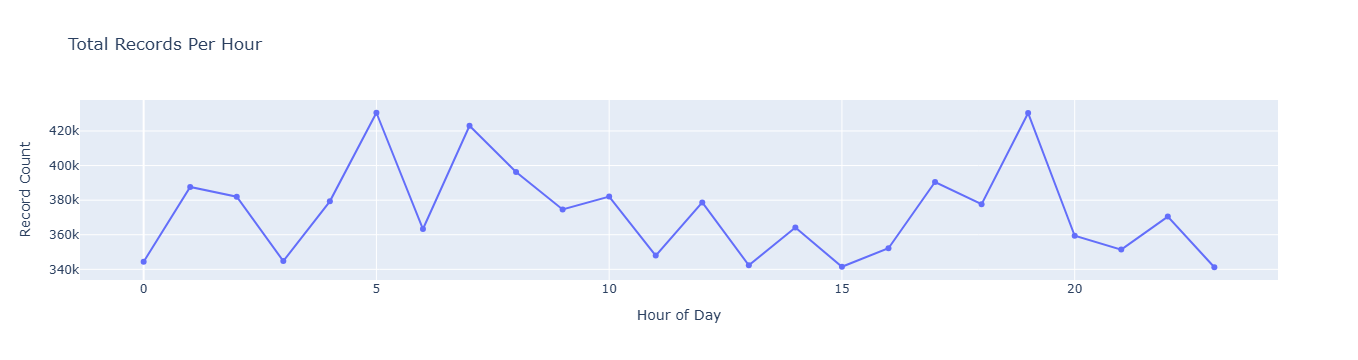

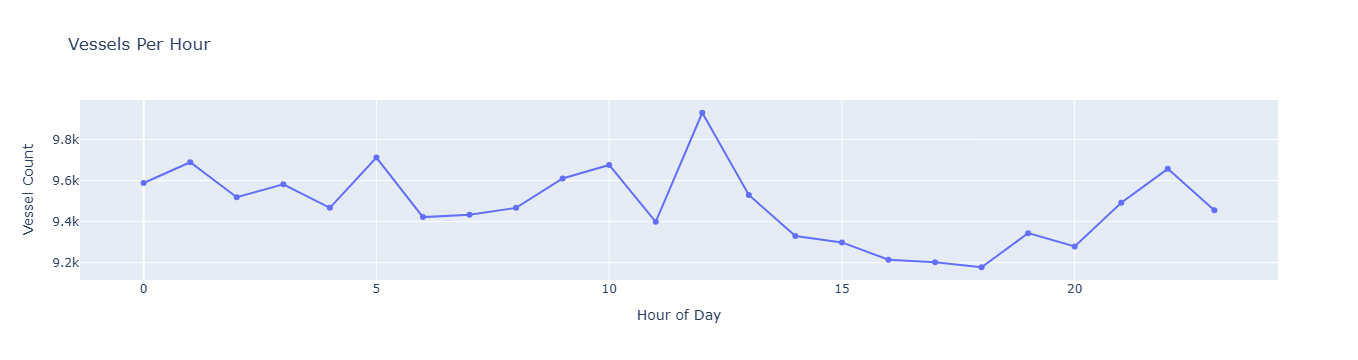

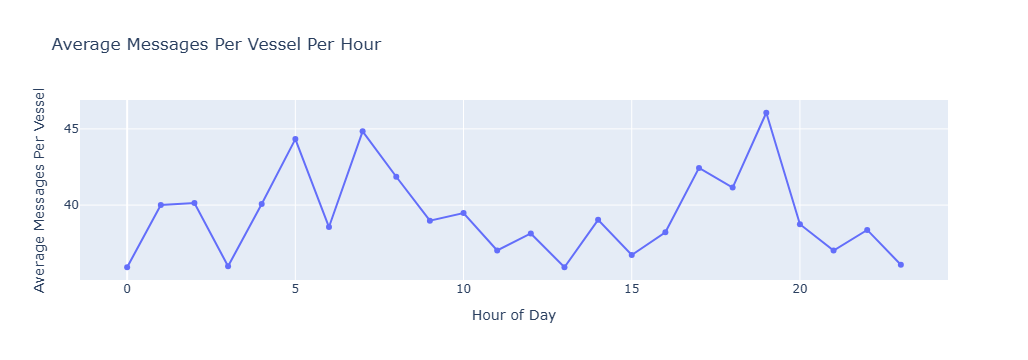

In [23]:
from pyspark.sql.functions import date_trunc, count, countDistinct, lag, avg
from pyspark.sql import functions as F
import plotly.express as px
import pandas as pd

# ------------
# Calculations
# ------------
# Dataframe containing data regarded as important for analysis
df_all = df_all.select("DateTime", "hour", "Message_Longitude", "Message_Latitude", "Message_UserID", "Message_MessageID")

# (1) Calculate the total count of rows per hour
totalRecordsPerHour = df_all.groupBy("hour").agg(count("*").alias("Records_per_hr")).orderBy("hour")

# (2) Calculate the distinct count of Message_UserID per hour
distinctVesselsPerHour = df_all.groupBy("hour").agg(countDistinct("Message_UserID").alias("Vessels")).orderBy("hour")

# (3) Calculate the average count of Message_MessageIDs by Message_UserID per hour
# Step A: Count messages per user per hour
messagesPerVesselPerHour = df_all.groupBy("hour", "Message_UserID").agg(count("Message_MessageID").alias("MessagesPerVessel"))
# Step B: Calculate the average of these counts per hour
avgMessagesPerVesselPerHour = messagesPerVesselPerHour.groupBy("hour").agg(F.round(avg("MessagesPerVessel"), 2).alias("AverageMessagesPerVesselPerHour")).orderBy("hour")

# (4) Join all the results into a single DataFrame
final_df = totalRecordsPerHour.join(distinctVesselsPerHour, on="hour", how="inner").join(avgMessagesPerVesselPerHour, on="hour", how="inner").orderBy("hour")
df_results = final_df.toPandas()

# ------
# Table
# ------
print("\n--- Aggregated Data Table ---")
# Apply some styling for better readability in Jupyter Notebook
styled_table = df_results.style \
    .set_properties(**{'background-color': '#f8f9fa', 'color': '#333', 'border-color': '#ddd'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#e9ecef'), ('color', '#495057'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '8px 12px')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f2f2f2')]}
    ]) \
    .format({"avg_messages_per_user_per_hour": "{:.2f}"}) # Format average column to 2 decimal places

# Display the styled table
display(styled_table) # 'display' is a Jupyter-specific function for rich output


# ------
# Charts
# ------
# Chart to call to show elemental time series activity for (A) Records per hour, (B) Vessels per hour, (C) Average Messages per Vessel per hour
def basic_time_series_chart(df, x_col, y_col, title, x_label, y_label):
    """
    Creates and displays a Plotly Express line chart.
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        x_col (str): The name of the column for the x-axis.
        y_col (str): The name of the column for the y-axis.
        title (str): The title of the chart.
        x_label (str): The label for the x-axis.
        y_label (str): The label for the y-axis.
    """
    fig = px.line(
        df,
        x=x_col,
        y=y_col,
        title=title,
        labels={
            x_col: x_label,
            y_col: y_label
        }
    )
    fig.update_traces(mode='lines+markers') # Show both lines and markers
    fig.update_layout(hovermode="x unified") # Unified hover for better comparison
    fig.show()

# Chart 1: Total Rows Count per Hour
basic_time_series_chart(df_results, x_col="hour", y_col="Records_per_hr", title="Total Records Per Hour", x_label="Hour of Day", y_label="Record Count")

# Chart 2: Vesseals per Hour
basic_time_series_chart(df_results, x_col="hour", y_col="Vessels", title="Vessels Per Hour", x_label="Hour of Day", y_label="Vessel Count")

# Chart 3: Average Messages per User per Hour
basic_time_series_chart(df_results, x_col="hour", y_col="AverageMessagesPerVesselPerHour", title="Average Messages Per Vessel Per Hour", x_label="Hour of Day", y_label="Average Messages Per Vessel")



# 06 - Basic Counts - Most messages per vessel
- The distribution of message counts per vessel is heavily right skewed (indicating that a majority of vessels - 12K - sent no more then 2000 messages during the day)
- That is at least 95% of all vessels (quick comparative inspection of the vessel counts and messages sent in the histogram)

Msgs per vessel over the day


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)



--- Aggregated Data Table ---


,Message_UserID,message_count
0,512007447,18311
1,512439000,16247
2,553111321,14157
3,512000113,13971
4,412000000,12998
5,635030000,12985
6,374316000,12345
7,259274000,12266
8,636013087,12263
9,5030273,11942


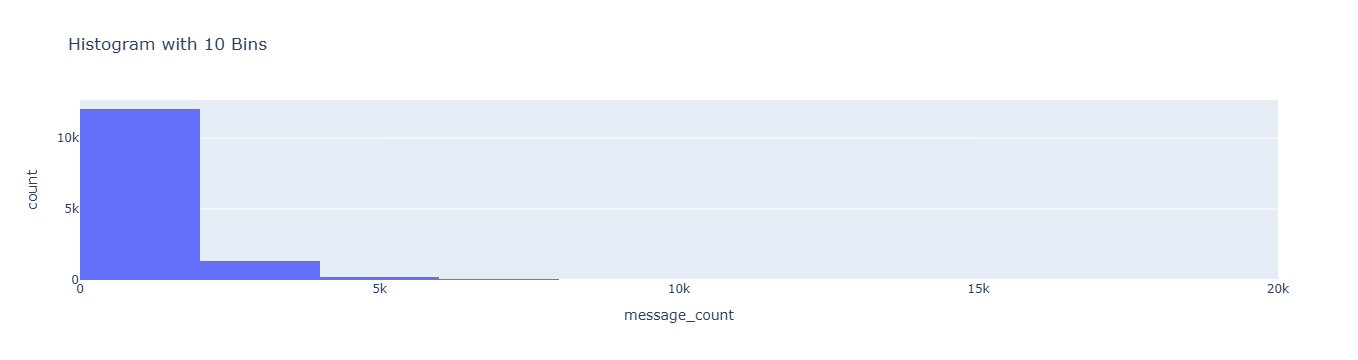

In [26]:
# Msgs per vessel
print("Msgs per vessel over the day")
df_MessageCountPerVessel = df_all.groupBy("Message_UserID").agg(count("Message_MessageID").alias("message_count")).orderBy(col("message_count").desc())

# Convert to pandas (to work with Plotly)
df_MessageCountPerVessel_pandas = df_MessageCountPerVessel.toPandas()

# ------
# Table
# ------
print("\n--- Aggregated Data Table ---")
# Apply some styling for better readability in Jupyter Notebook
styled_table2 = df_MessageCountPerVessel_pandas.head(25).style \
    .set_properties(**{'background-color': '#f8f9fa', 'color': '#333', 'border-color': '#ddd'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#e9ecef'), ('color', '#495057'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '8px 12px')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f2f2f2')]}
    ]) \
    .format({"avg_messages_per_user_per_hour": "{:.2f}"}) # Format average column to 2 decimal places

display(styled_table2) # 'display' is a Jupyter-specific function for rich output

# Inspect the distribution of messages counts per Vessel using customised bins
fig_MessageCountPerVessel_pandas = px.histogram(df_MessageCountPerVessel_pandas, x='message_count', nbins=10, title='Histogram with 10 Bins')
fig_MessageCountPerVessel_pandas.show()

# 07 - Basic Counts - Distance covered that day
- Using the longitude/latitude traversed over the day, we can use the haversine formula to estimate the distance travelled per vessel
- This section creates and registers the haversine function as a registered spark user defined function (which will allow me to calculate distances travelled in kms)
- The section after that calculates the distances travelled per vessel
- As a result, the data looks odd (some vessels traversing beyond the speed of light per hour). Would have tested/checked but ran out of time. To be continued some other time :-)

In [7]:
# Earth radius in kilometers (can use miles, meters, etc.)
R = 6371.0 # km

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees) using the Haversine formula.
    Returns distance in kilometers.
    """
    if None in [lat1, lon1, lat2, lon2]:
        return None

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

# Register the UDF with Spark
# We specify the return type as DoubleType
haversine_udf = F.udf(haversine, DoubleType())

# Ensure the UDF is available in Spark SQL if you plan to use it there
spark.udf.register("haversine_distance", haversine, DoubleType())

<function __main__.haversine(lat1, lon1, lat2, lon2)>

In [8]:
import math
from pyspark.sql.window import Window

# Creates dataframes which organise data and fields in preparation to calculate distances travelled - using the haversine defined function
print("In Order")
df_compute = df_all.select("DateTime", "Message_UserID", "hour", "Message_Longitude", "Message_Latitude") \
                    .distinct() \
                    .orderBy(col("Message_UserID").desc(), col("DateTime").asc())

window_spec = Window.partitionBy("Message_UserID").orderBy("DateTime")
df_compute2 = df_compute.withColumn("prev_longitude", lag("Message_Longitude").over(window_spec)) \
                        .withColumn("prev_latitude", lag("Message_Latitude").over(window_spec)) \
                        .withColumn("previous_time", lag("DateTime").over(window_spec))

df_with_distance = df_compute2.withColumn("distance_km",
                                          haversine_udf(F.col("prev_latitude"), F.col("prev_longitude"),
                                                        F.col("Message_Latitude"), F.col("Message_Longitude")
                                                       )
                                           )
df_with_distance = df_with_distance.fillna(0, subset=['distance_km'])
df_with_distance.show()


# Estimate the distance travelled per hour by vessel for the given day
df_with_distance_short = df_with_distance.groupBy("Message_UserID", "hour").agg(F.sum("distance_km").alias("distance_travelled_perhr")).orderBy(col("Message_UserID").desc(), col("hour").asc())
df_with_distance_short.show()                                               

In Order


+-------------------+--------------+----+-----------------+----------------+--------------+-------------+-------------------+-------------------+
|           DateTime|Message_UserID|hour|Message_Longitude|Message_Latitude|prev_longitude|prev_latitude|      previous_time|        distance_km|
+-------------------+--------------+----+-----------------+----------------+--------------+-------------+-------------------+-------------------+
|2020-05-05 01:02:26|           103|   1|             NULL|            NULL|          NULL|         NULL|               NULL|                0.0|
|2020-05-05 01:09:10|           103|   1|             NULL|            NULL|          NULL|         NULL|2020-05-05 01:02:26|                0.0|
|2020-05-05 01:09:11|           103|   1|             NULL|            NULL|          NULL|         NULL|2020-05-05 01:09:10|                0.0|
|2020-05-05 01:42:47|           103|   1|       159.058918|      -12.708233|          NULL|         NULL|2020-05-05 01:09:11

+--------------+----+------------------------+
|Message_UserID|hour|distance_travelled_perhr|
+--------------+----+------------------------+
|     999999999|   0|       311113.6629248179|
|     999999999|   1|       455457.4576488176|
|     999999999|   2|       352007.5026229549|
|     999999999|   3|       274071.1599876799|
|     999999999|   4|       369817.7277278367|
|     999999999|   5|      315698.37570982194|
|     999999999|   6|      451069.49659063143|
|     999999999|   7|       237134.4754313951|
|     999999999|   8|      373003.98395291483|
|     999999999|   9|      321549.02678643854|
|     999999999|  10|      415965.51369641075|
|     999999999|  11|      359425.46854601527|
|     999999999|  12|       431060.4941661193|
|     999999999|  13|       339773.4101455887|
|     999999999|  14|       435760.8027229946|
|     999999999|  15|       300317.3136266644|
|     999999999|  16|       226174.2842078958|
|     999999999|  17|       414159.7215276027|
|     9999999

# 08 Basic Geospatial Analysis - Determine where vessels (within given regions) were
- As the dataset is quite large, this example just serves to determine where vessels were during the day
- Grid sizes were used to group and count vessels that were close to one another (i.e. those within a proximity within a region).
- The map indicates the count of vessels within proximity to one another, within a region, across the given day

Aggregated Spark DataFrame (Grid Counts):


+--------+--------+---------------------+
|grid_lat|grid_lon|distinct_vessel_count|
+--------+--------+---------------------+
|    NULL|    NULL|                 9789|
|   -10.0|   110.0|                 1621|
|   -10.0|   100.0|                 1292|
|   -10.0|   130.0|                  823|
|   -30.0|   150.0|                  662|
|   -10.0|    70.0|                  499|
|   -40.0|   150.0|                  474|
|   -40.0|    10.0|                  459|
|   -10.0|   120.0|                  435|
|   -40.0|    20.0|                  425|
|   -10.0|    10.0|                  379|
|   -30.0|   110.0|                  357|
|   -40.0|   170.0|                  327|
|   -10.0|    50.0|                  321|
|   -10.0|    40.0|                  317|
|   -40.0|    30.0|                  291|
|   -10.0|   140.0|                  278|
|   -30.0|    50.0|                  261|
|   -30.0|    30.0|                  259|
|   -20.0|   150.0|                  255|
+--------+--------+---------------

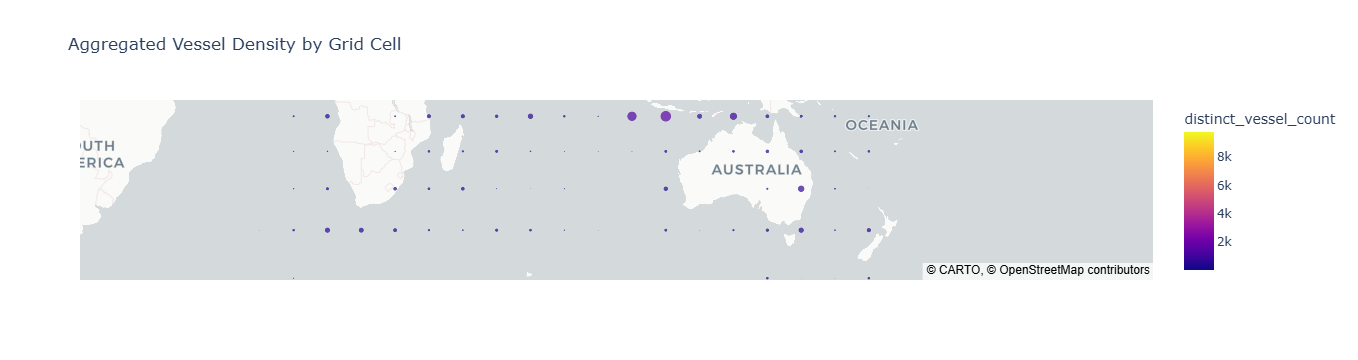

In [9]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import plotly.express as px

# Define grid size (e.g., 10 degrees)
grid_size = 10.0

# Calculate grid cell for each point
# Using F.floor to assign points to a grid cell.
# You might need to adjust the calculation for global coverage or specific projections.
binned_df = df_all.withColumn(
    "grid_lat", (F.floor(F.col("Message_Latitude") / grid_size) * grid_size).cast("float")
).withColumn(
    "grid_lon", (F.floor(F.col("Message_Longitude") / grid_size) * grid_size).cast("float")
)

# Aggregate (e.g., count distinct vessels per grid cell)
aggregated_df_spark = binned_df.groupBy("grid_lat", "grid_lon").agg(
    F.countDistinct("Message_UserID").alias("distinct_vessel_count")).orderBy(col("distinct_vessel_count").desc())

print("Aggregated Spark DataFrame (Grid Counts):")
aggregated_df_spark.show()

# Convert the smaller aggregated Spark DataFrame to Pandas for plotting
aggregated_df_pandas = aggregated_df_spark.toPandas()

# Now you can use Plotly, Folium, or Matplotlib to plot 'aggregated_df_pandas'
# using 'grid_lat', 'grid_lon', and 'distinct_vessel_count' as your data points.
# For instance, a scatter map with point size/color based on 'distinct_vessel_count'.

# Example Plotly scatter map with aggregated data:
fig_agg = px.scatter_map(
    aggregated_df_pandas,
    lat="grid_lat",
    lon="grid_lon",
    size="distinct_vessel_count", # Use count to determine marker size
    color="distinct_vessel_count", # Use count to determine marker color
    color_continuous_scale=px.colors.sequential.Plasma,
    zoom=2,
    map_style="carto-positron",
    title="Aggregated Vessel Density by Grid Cell"
)
fig_agg.show()

# spark.stop()

# 09 Basic Geospatial Analysis - Determine where vessels (within given regions) were (within 4 hour blocks)
- As the dataset is quite large, this example just serves to determine where vessels were during the day
- Grid sizes were used to group and count vessels that were close to one another (i.e. those within a proximity within a region).
- The map indicates the count of vessels within proximity to one another, within a region, across the given day in 4hr blocks

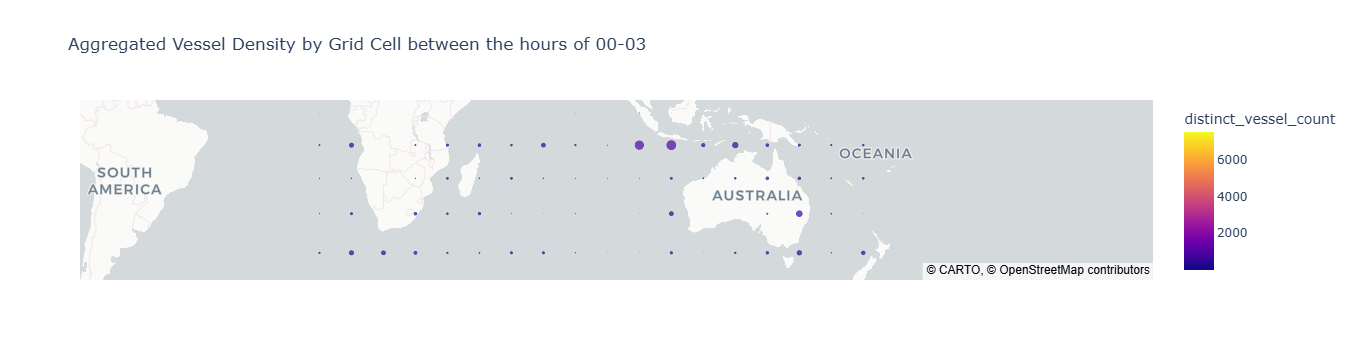

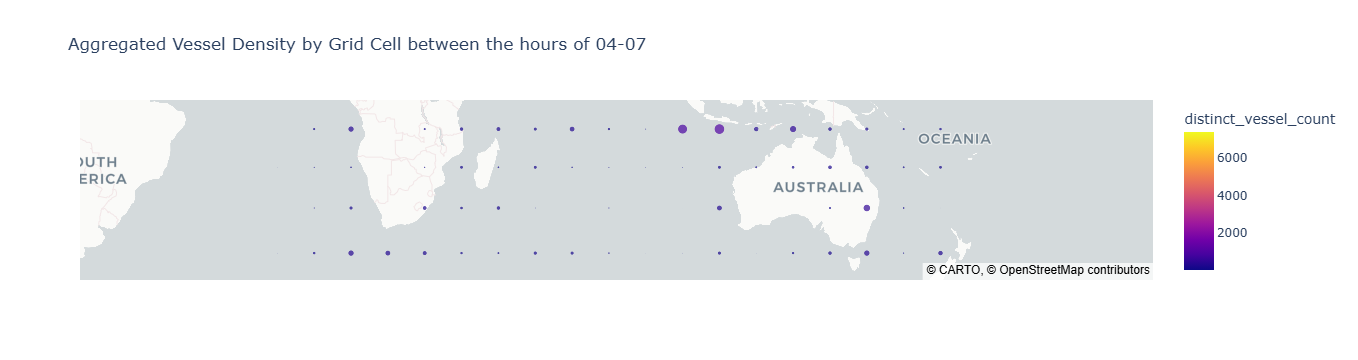

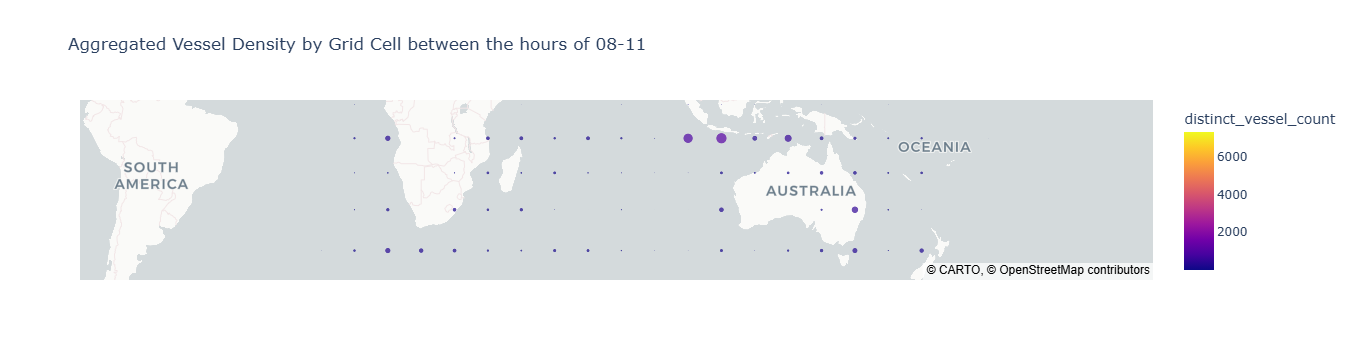

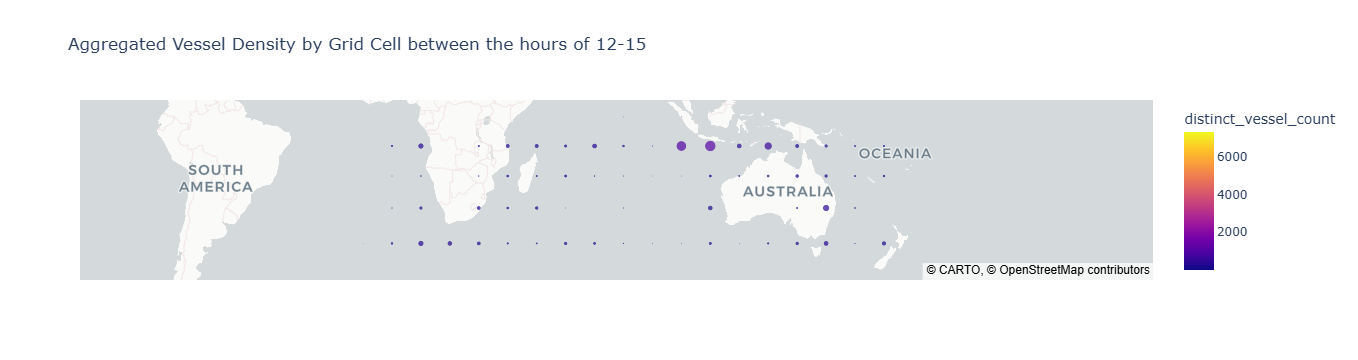

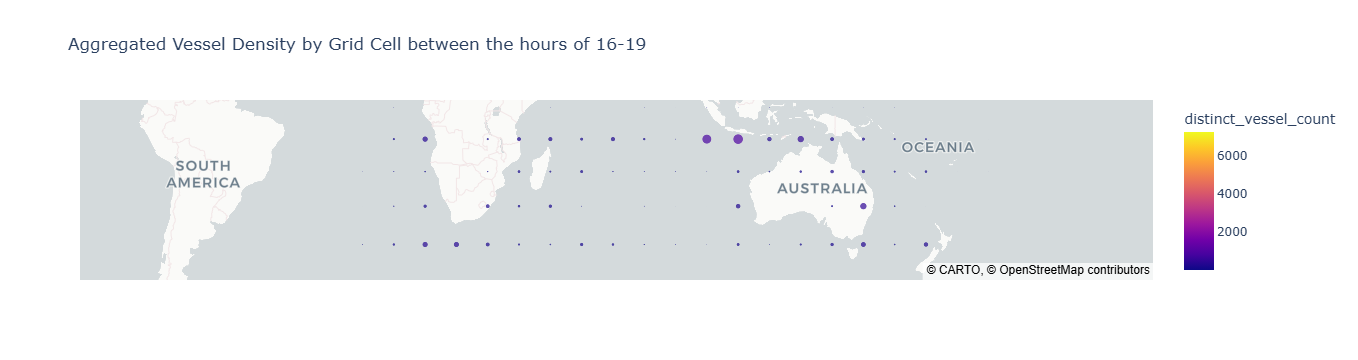

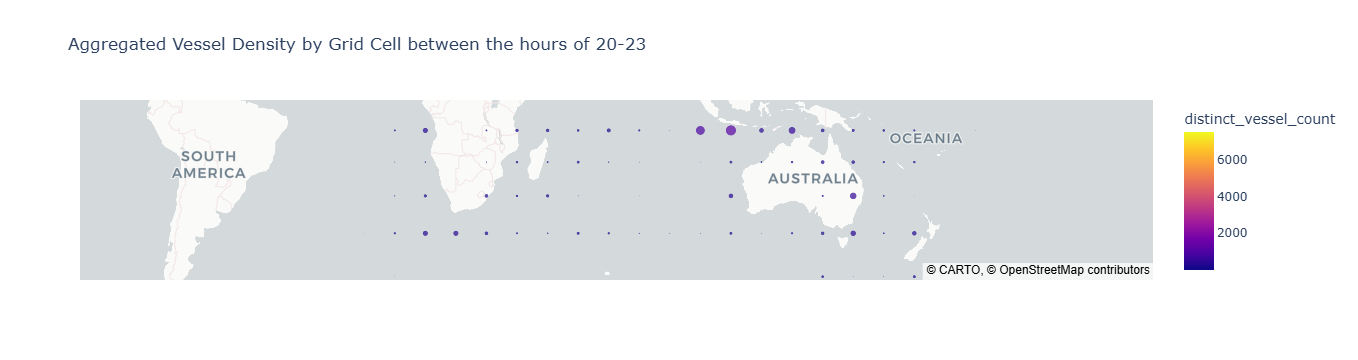

In [10]:
import pandas as pd
import plotly.express as px

# Define the bin edges and labels
bins = [-1, 3, 7, 11, 15, 19, 23] # -1 to 3 for 0-3, etc.
labels = ['00-03', '04-07', '08-11', '12-15', '16-19', '20-23']

# Create the 'hour_bin' column
binned_spark_df = df_all.withColumn("hour_bin",
    F.when((F.col("hour") >= 0) & (F.col("hour") <= 3), "00-03") \
    .when((F.col("hour") >= 4) & (F.col("hour") <= 7), "04-07") \
    .when((F.col("hour") >= 8) & (F.col("hour") <= 11), "08-11") \
    .when((F.col("hour") >= 12) & (F.col("hour") <= 15), "12-15") \
    .when((F.col("hour") >= 16) & (F.col("hour") <= 19), "16-19") \
    .when((F.col("hour") >= 20) & (F.col("hour") <= 23), "20-23") \
    .otherwise("Unknown_Hour_Bin") # Handle hours outside 0-23 if necessary
)

# Get unique bins from the Spark DataFrame for iteration
# You'll need to collect these labels to the driver first
unique_bins = [row.hour_bin for row in binned_spark_df.select("hour_bin").distinct().collect()]
unique_bins = sorted([b for b in unique_bins if b is not None]) # Filter out any None/Unknown and sort


# Calculate a center for the map based on the current bin's data
#center_lat = binned_spark_df['Message_Latitude'].mean()
#center_lon = binned_spark_df['Message_Longitude'].mean()
center_lat = binned_spark_df.agg(F.mean("Message_Latitude"))
center_lon = binned_spark_df.agg(F.mean("Message_Longitude"))



# Create a map for each hour bin
for h_bin in unique_bins:
    df_filtered = binned_spark_df[binned_spark_df['hour_bin'] == h_bin]

    if df_filtered:
        # Define grid size (e.g., 10 degrees)
        grid_size = 10.0
        
        # Calculate grid cell for each point
        # Using F.floor to assign points to a grid cell.
        # You might need to adjust the calculation for global coverage or specific projections.
        binned_df = df_filtered.withColumn(
            "grid_lat", (F.floor(F.col("Message_Latitude") / grid_size) * grid_size).cast("float")
        ).withColumn(
            "grid_lon", (F.floor(F.col("Message_Longitude") / grid_size) * grid_size).cast("float")
        )
        
        # Aggregate (e.g., count distinct vessels per grid cell)
        aggregated_df_spark = binned_df.groupBy("grid_lat", "grid_lon").agg(
            F.countDistinct("Message_UserID").alias("distinct_vessel_count")).orderBy(col("distinct_vessel_count").desc())

        aggregated_df_pandas = aggregated_df_spark.toPandas()
        
        fig_agg = px.scatter_map(
            aggregated_df_pandas,
            lat="grid_lat",
            lon="grid_lon",
            size="distinct_vessel_count", # Use count to determine marker size
            color="distinct_vessel_count", # Use count to determine marker color
            color_continuous_scale=px.colors.sequential.Plasma,
            zoom=2,
            map_style="carto-positron",
            title=f"Aggregated Vessel Density by Grid Cell between the hours of {h_bin}"
        )
        fig_agg.show()

    else:
        print(f"No data for hour bin: {h_bin}")

In [11]:
spark.stop()